In [1]:
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fileName = '../../ETOPO1_Ice_c_gmt4.grd'

fh = Dataset(fileName, mode='r')

fh.variables.keys()

x = fh.variables['x']
y = fh.variables['y']
z = fh.variables['z']

In [3]:
dx = np.diff(x[:])[0]
dy = np.diff(y[:])[0]
print('dx={}, dy={}'.format(dx,dy))

dx=0.01666666666667993, dy=0.01666666666666572


I want the rectangle $ (lon,lat) \in [-240,-120] \times [-60, 60] $, but can only use  $lon \in[-180,180]$, hence have to use the joined set: $$lon \in [120,180] \cup [-180,-120]$$

# Pick a subrectangle centered on the pacific 

In [4]:
y0 = -85
y1 = 85
j0 = int((y0+90)*60)
j1 = int((y1+90)*60)

(0.0, 108.0, 0.0, 204.0)

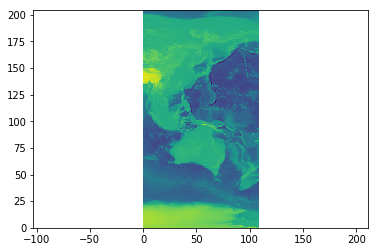

In [5]:
x0 = 90
x1 = 180
i0 = int((x0+180)*60)
i1 = int((x1+180)*60)

plt.pcolormesh(z[j0:j1:50,i0:i1:50])
plt.axis('equal')

(0.0, 175.0, 0.0, 204.0)

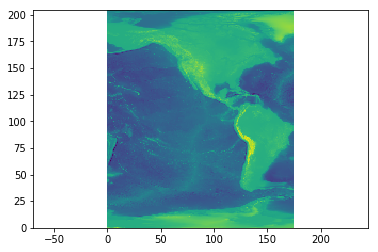

In [6]:
x2 = -34.17
i2 = int((x2+180)*60)

plt.pcolormesh(z[j0:j1:50,:i2:50])
plt.axis('equal')

Select bathymetry from range and skip some values

In [7]:
skip = 3
zfinal = np.hstack([z[j0:j1:skip,i0:i1:skip], z[j0:j1:skip,:i2:skip]])
zfinal = zfinal
print('Mesh size:', zfinal.shape)

Mesh size: (3400, 4717)


zfinal_backup = zfinal*1.0

zfinal = np.where(zfinal_backup<0,zfinal_backup,zfinal_backup)

(0.0, 472.0, 0.0, 340.0)

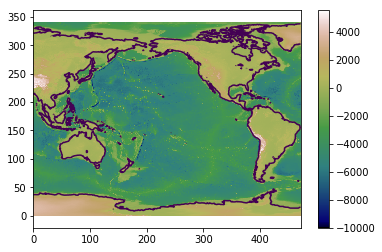

In [8]:
plt.pcolormesh(zfinal[::10,::10],cmap=plt.cm.gist_earth)
plt.colorbar()
plt.contour(zfinal[::10,::10],[0.0])
plt.axis('equal')

np.savetxt('bathymetry',-zfinal[::1,::1])

In [9]:
arr = np.hstack([zfinal.shape[0],zfinal.shape[1],(-zfinal).ravel()])

In [13]:
file = 'bathymetry{}min'.format(skip)
arr.astype('float64').tofile('bathymetry{}min'.format(skip))
print(file)

bathymetry3min


np.savetxt('bathymetry{}min'.format(skip), arr.data)

# Easywave

In [14]:
def writeGRD(z,name, xll, xur, yll, yur):
    ncols = z.shape[1]
    nrows = z.shape[0]
    f = open(name,'w')
    f.write('DSAA\n')
    print('DSAA\n')
    f.write('%i %i\n'%(ncols, nrows))
    print('%i %i\n'%(ncols, nrows))
    f.write('%.3f %.3f\n'%(xll,xur))
    print('%.3f %.3f\n'%(xll,xur))
    f.write('%.3f %.3f\n'%(yll,yur))
    print('%.3f %.3f\n'%(yll,yur))


    f.write('%.3f %.3f\n'%(z.min(),z.max()))

    s = [' '.join(['%.5f '%num for num in z[-i,:]]) for i in range(z.shape[0])]

    for ss in s:
        f.write('%s\n'%ss)
    f.close()

# writeGRD(np.flipud(z),'bathymetry{}mins.grd'.format(k))

In [33]:
y0 = -70
y1 = 70
j0 = int((y0+90)*60)
j1 = int((y1+90)*60)
x0 = 90
x1 = 180
i0 = int((x0+180)*60)
i1 = int((x1+180)*60)
x2 = 290-360
i2 = int((x2+180)*60)

In [34]:
skip = 3
zewave = np.hstack([z[j0:j1:skip,i0:i1:skip], z[j0:j1:skip,:i2:skip]])
print('Mesh size:', zewave.shape)

Mesh size: (2800, 4000)


In [35]:
print(x0,x2+360)
print(y0,y1)

90 290
-70 70


In [36]:
zfinal.shape

(2600, 4717)

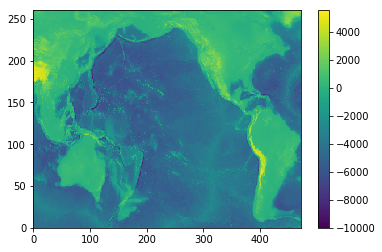

In [37]:
plt.pcolormesh(zfinal[::10,::10])
plt.colorbar()

In [42]:
writeGRD(np.flipud(zewave), 'bathymetryEasywave_{}min.grd'.format(skip), x0, x2+360, y0, y1)

DSAA

4000 2800

90.000 290.000

-70.000 70.000

